### Menggunakan Arsitektur ResNet 3D

In [15]:
import os
import cv2
import torch
import random
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision.models.video import r3d_18, R3D_18_Weights # Import Weights Manager

# --- KONFIGURASI ---
DATA_ROOT = "/run/media/han/HDD RAIHAN/Real Dataset Cheating Comvis/Preprocessing/dataset_clips_split_ready"
CLIP_LEN = 32
RESIZE = 112
BATCH_SIZE = 8
LR = 0.0001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device yang digunakan: {DEVICE}")

Device yang digunakan: cuda


In [16]:
class VideoClipDataset(Dataset):
    def __init__(self, root, clip_len=32, resize=112):
        self.root = root
        self.clip_len = clip_len
        self.resize = resize
        self.samples = []

        if os.path.exists(root):
            self.classes = sorted(os.listdir(root)) # Simpan nama kelas
            self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

            for cls in self.classes:
                cls_dir = os.path.join(root, cls)
                if not os.path.isdir(cls_dir): continue
                for fname in os.listdir(cls_dir):
                    if fname.endswith(".mp4"):
                        self.samples.append((os.path.join(cls_dir, fname),
                                             self.class_to_idx[cls]))
            print(f"[INFO] Loaded {len(self.samples)} clips from {root}")
        else:
            print(f"[ERROR] Path tidak ditemukan: {root}")
            self.classes = []

    def __len__(self):
        return len(self.samples)

    def _sample_frames(self, cap, total_frames):
        frames = []
        needed = self.clip_len

        if total_frames <= 0:
            return torch.zeros((3, needed, self.resize, self.resize), dtype=torch.float32)

        if total_frames > needed:
            start = random.randint(0, total_frames - needed)
        else:
            start = 0

        cap.set(cv2.CAP_PROP_POS_FRAMES, start)

        count = 0
        max_retries = 5
        retries = 0

        while count < needed:
            ret, frame = cap.read()
            if not ret:
                cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
                retries += 1
                if retries > max_retries:
                    black_frame = np.zeros((self.resize, self.resize, 3), dtype=np.uint8)
                    frames.append(black_frame)
                    count += 1
                continue

            retries = 0
            try:
                frame = cv2.resize(frame, (self.resize, self.resize))
                frame = frame[:, :, ::-1]
                frames.append(frame)
                count += 1
            except:
                retries += 1
                continue

        frames = np.stack(frames)
        frames = frames.transpose(3, 0, 1, 2) / 255.0
        return torch.tensor(frames, dtype=torch.float32)

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        cap = cv2.VideoCapture(video_path)
        total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        clip = self._sample_frames(cap, total)
        cap.release()
        return clip, torch.tensor(label)

In [17]:
train_path = os.path.join(DATA_ROOT, "train")
val_path = os.path.join(DATA_ROOT, "val")
test_path = os.path.join(DATA_ROOT, "test")  # <--- PATH TEST DITAMBAHKAN

print("--- Memuat Dataset ---")
train_set = VideoClipDataset(train_path, CLIP_LEN, RESIZE)
val_set   = VideoClipDataset(val_path,   CLIP_LEN, RESIZE)
test_set  = VideoClipDataset(test_path,  CLIP_LEN, RESIZE) # <--- DATASET TEST

# Simpan nama kelas untuk keperluan plotting nanti
class_names = train_set.classes

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2) # <--- LOADER TEST

print("✅ Semua DataLoader (Train, Val, Test) Siap!")

--- Memuat Dataset ---
[INFO] Loaded 1865 clips from /run/media/han/HDD RAIHAN/Real Dataset Cheating Comvis/Preprocessing/dataset_clips_split_ready/train
[INFO] Loaded 392 clips from /run/media/han/HDD RAIHAN/Real Dataset Cheating Comvis/Preprocessing/dataset_clips_split_ready/val
[INFO] Loaded 404 clips from /run/media/han/HDD RAIHAN/Real Dataset Cheating Comvis/Preprocessing/dataset_clips_split_ready/test
✅ Semua DataLoader (Train, Val, Test) Siap!


In [18]:
# --- MODEL SETUP DENGAN TRANSFER LEARNING & AUTO WEIGHTS ---

print("📥 Sedang mendownload otak pintar (Kinetics-400 Weights)...")
# 1. Load Model dengan Bobot Kinetics-400
weights = R3D_18_Weights.KINETICS400_V1
model = r3d_18(weights=weights)

# 2. Bekukan (Freeze) sebagian layer
for name, param in model.named_parameters():
    if "layer4" not in name and "fc" not in name: # Kecuali layer 4 dan FC
        param.requires_grad = False

# 3. Ganti Kepala Model (Output Layer)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(DEVICE)

# --- HITUNG CLASS WEIGHTS OTOMATIS ---
print("\n⚖️ Menghitung Class Weights secara Otomatis...")

# Ambil semua label dari dataset training
# train_set.samples berisi list [(path, label_idx), ...]
train_labels = [label for _, label in train_set.samples]

# Hitung jumlah sampel per kelas
# class_counts[0] = jumlah kelas 0, class_counts[1] = jumlah kelas 1
class_counts = np.bincount(train_labels)
total_samples = len(train_labels)
num_classes = len(class_counts)

# Rumus Balanced Weights: n_samples / (n_classes * n_samples_j)
class_weights_np = total_samples / (num_classes * class_counts)

# Convert ke Tensor PyTorch dan pindahkan ke GPU/CPU
class_weights = torch.tensor(class_weights_np, dtype=torch.float32).to(DEVICE)

print(f"   -> Jumlah Data Train: {total_samples}")
print(f"   -> Detail per Kelas : {class_counts} (0: Cheating, 1: Not Cheating)")
print(f"   -> Calculated Weights: {class_weights.cpu().numpy()}")
print("-" * 40)

# 4. Optimizer & Loss Function
params_to_update = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params_to_update, lr=LR)

# Masukkan weights otomatis ke dalam CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=class_weights)
scaler = torch.amp.GradScaler('cuda')

print("✅ Model Siap! Loss Function menggunakan bobot otomatis.")

# --- CLASS EARLY STOPPING ---
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            print(f'   -> EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        print(f'   -> Val loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Fungsi Train
def train_epoch():
    model.train()
    total_loss, correct, total = 0, 0, 0
    for clips, labels in tqdm(train_loader, desc="Training"):
        clips, labels = clips.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            outputs = model(clips)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item() * clips.size(0)
        _, pred = outputs.max(1)
        correct += pred.eq(labels).sum().item()
        total += labels.size(0)
    return total_loss/total, correct/total

# Fungsi Validasi
def val_epoch():
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for clips, labels in tqdm(val_loader, desc="Validation"):
            clips, labels = clips.to(DEVICE), labels.to(DEVICE)
            outputs = model(clips)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * clips.size(0)
            _, pred = outputs.max(1)
            correct += pred.eq(labels).sum().item()
            total += labels.size(0)
    return total_loss/total, correct/total

📥 Sedang mendownload otak pintar (Kinetics-400 Weights)...
Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /home/han/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth


100%|██████████| 127M/127M [01:37<00:00, 1.36MB/s] 


⚖️ Menghitung Class Weights secara Otomatis...
   -> Jumlah Data Train: 1865
   -> Detail per Kelas : [ 558 1307] (0: Cheating, 1: Not Cheating)
   -> Calculated Weights: [1.671147  0.7134659]
----------------------------------------
✅ Model Siap! Loss Function menggunakan bobot otomatis.


In [19]:
EPOCHS = 100
PATIENCE = 7
SAVE_PATH = "/home/han/Documents/Kuliah/S5/Comvis/Projek/r3d_18_cheating_best_v3.pth"

early_stopping = EarlyStopping(patience=PATIENCE, path=SAVE_PATH)

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

print("\n🚀 Mulai Training R3D-18...")

for epoch in range(EPOCHS):
    print(f"\n=== EPOCH {epoch+1}/{EPOCHS} ===")

    train_loss, train_acc = train_epoch()
    val_loss, val_acc = val_epoch()

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print("\n🛑 Early stopping triggered!")
        break

print("\n✅ Training Selesai.")


🚀 Mulai Training R3D-18...

=== EPOCH 1/100 ===


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.72it/s]


Train Loss: 0.3400 | Train Acc: 0.8520
Val   Loss: 0.1826 | Val   Acc: 0.9158
   -> Val loss decreased (inf --> 0.182632). Saving model...

=== EPOCH 2/100 ===


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.73it/s]


Train Loss: 0.1556 | Train Acc: 0.9432
Val   Loss: 0.1205 | Val   Acc: 0.9617
   -> Val loss decreased (0.182632 --> 0.120492). Saving model...

=== EPOCH 3/100 ===


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.67it/s]


Train Loss: 0.0817 | Train Acc: 0.9705
Val   Loss: 0.1153 | Val   Acc: 0.9566
   -> Val loss decreased (0.120492 --> 0.115298). Saving model...

=== EPOCH 4/100 ===


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.63it/s]


Train Loss: 0.0774 | Train Acc: 0.9732
Val   Loss: 0.1008 | Val   Acc: 0.9566
   -> Val loss decreased (0.115298 --> 0.100797). Saving model...

=== EPOCH 5/100 ===


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.62it/s]


Train Loss: 0.0696 | Train Acc: 0.9812
Val   Loss: 0.0664 | Val   Acc: 0.9770
   -> Val loss decreased (0.100797 --> 0.066402). Saving model...

=== EPOCH 6/100 ===


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.61it/s]


Train Loss: 0.0804 | Train Acc: 0.9764
Val   Loss: 0.0599 | Val   Acc: 0.9694
   -> Val loss decreased (0.066402 --> 0.059943). Saving model...

=== EPOCH 7/100 ===


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


Train Loss: 0.0601 | Train Acc: 0.9807
Val   Loss: 0.0717 | Val   Acc: 0.9745
   -> EarlyStopping counter: 1 out of 7

=== EPOCH 8/100 ===


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.60it/s]


Train Loss: 0.0391 | Train Acc: 0.9882
Val   Loss: 0.0581 | Val   Acc: 0.9719
   -> Val loss decreased (0.059943 --> 0.058103). Saving model...

=== EPOCH 9/100 ===


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.58it/s]


Train Loss: 0.0416 | Train Acc: 0.9887
Val   Loss: 0.0708 | Val   Acc: 0.9719
   -> EarlyStopping counter: 1 out of 7

=== EPOCH 10/100 ===


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.58it/s]


Train Loss: 0.0257 | Train Acc: 0.9941
Val   Loss: 0.0646 | Val   Acc: 0.9847
   -> EarlyStopping counter: 2 out of 7

=== EPOCH 11/100 ===


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.59it/s]


Train Loss: 0.0247 | Train Acc: 0.9936
Val   Loss: 0.0577 | Val   Acc: 0.9796
   -> Val loss decreased (0.058103 --> 0.057675). Saving model...

=== EPOCH 12/100 ===


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.58it/s]


Train Loss: 0.0242 | Train Acc: 0.9930
Val   Loss: 0.0711 | Val   Acc: 0.9694
   -> EarlyStopping counter: 1 out of 7

=== EPOCH 13/100 ===


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.57it/s]


Train Loss: 0.0158 | Train Acc: 0.9941
Val   Loss: 0.1191 | Val   Acc: 0.9566
   -> EarlyStopping counter: 2 out of 7

=== EPOCH 14/100 ===


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.57it/s]


Train Loss: 0.0341 | Train Acc: 0.9903
Val   Loss: 0.0798 | Val   Acc: 0.9719
   -> EarlyStopping counter: 3 out of 7

=== EPOCH 15/100 ===


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


Train Loss: 0.0178 | Train Acc: 0.9952
Val   Loss: 0.1106 | Val   Acc: 0.9770
   -> EarlyStopping counter: 4 out of 7

=== EPOCH 16/100 ===


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


Train Loss: 0.0143 | Train Acc: 0.9952
Val   Loss: 0.1191 | Val   Acc: 0.9668
   -> EarlyStopping counter: 5 out of 7

=== EPOCH 17/100 ===


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.57it/s]


Train Loss: 0.0071 | Train Acc: 0.9989
Val   Loss: 0.0460 | Val   Acc: 0.9796
   -> Val loss decreased (0.057675 --> 0.046045). Saving model...

=== EPOCH 18/100 ===


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


Train Loss: 0.0217 | Train Acc: 0.9914
Val   Loss: 0.0431 | Val   Acc: 0.9821
   -> Val loss decreased (0.046045 --> 0.043112). Saving model...

=== EPOCH 19/100 ===


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.55it/s]


Train Loss: 0.0251 | Train Acc: 0.9936
Val   Loss: 0.1152 | Val   Acc: 0.9617
   -> EarlyStopping counter: 1 out of 7

=== EPOCH 20/100 ===


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.57it/s]


Train Loss: 0.0171 | Train Acc: 0.9952
Val   Loss: 0.0733 | Val   Acc: 0.9770
   -> EarlyStopping counter: 2 out of 7

=== EPOCH 21/100 ===


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


Train Loss: 0.0122 | Train Acc: 0.9957
Val   Loss: 0.0784 | Val   Acc: 0.9745
   -> EarlyStopping counter: 3 out of 7

=== EPOCH 22/100 ===


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


Train Loss: 0.0210 | Train Acc: 0.9952
Val   Loss: 0.1149 | Val   Acc: 0.9719
   -> EarlyStopping counter: 4 out of 7

=== EPOCH 23/100 ===


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


Train Loss: 0.0060 | Train Acc: 0.9989
Val   Loss: 0.0914 | Val   Acc: 0.9592
   -> EarlyStopping counter: 5 out of 7

=== EPOCH 24/100 ===


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]


Train Loss: 0.0099 | Train Acc: 0.9979
Val   Loss: 0.0642 | Val   Acc: 0.9770
   -> EarlyStopping counter: 6 out of 7

=== EPOCH 25/100 ===


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.56it/s]

Train Loss: 0.0075 | Train Acc: 0.9984
Val   Loss: 0.1469 | Val   Acc: 0.9592
   -> EarlyStopping counter: 7 out of 7

🛑 Early stopping triggered!

✅ Training Selesai.


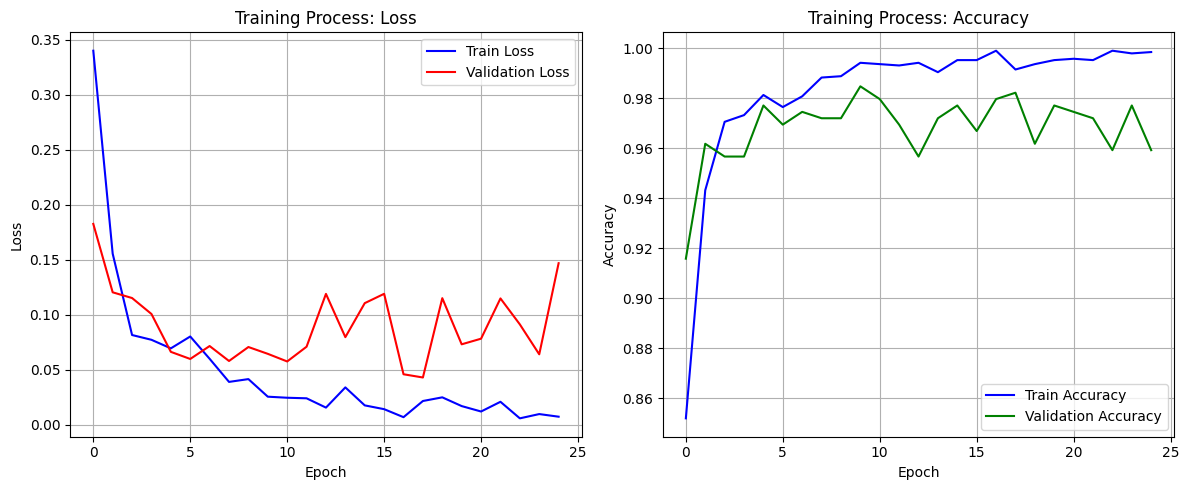

In [20]:
# --- PLOT GRAFIK TRAINING vs VALIDATION ---
plt.figure(figsize=(12, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='red')
plt.title('Training Process: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy', color='blue')
plt.plot(history['val_acc'], label='Validation Accuracy', color='green')
plt.title('Training Process: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


       MULAI PENGUJIAN DATA TEST       
📥 Memuat model terbaik dari: /home/han/Documents/Kuliah/S5/Comvis/Projek/r3d_18_cheating_best_v3.pth
🔄 Sedang memprediksi data test...


Testing: 100%|██████████| 51/51 [00:14<00:00,  3.60it/s]



✅ Total Test Accuracy: 94.31%
----------------------------------------

DETAIL LAPORAN KLASIFIKASI:
              precision    recall  f1-score   support

    cheating       0.99      0.83      0.90       126
not_cheating       0.93      1.00      0.96       278

    accuracy                           0.94       404
   macro avg       0.96      0.91      0.93       404
weighted avg       0.95      0.94      0.94       404



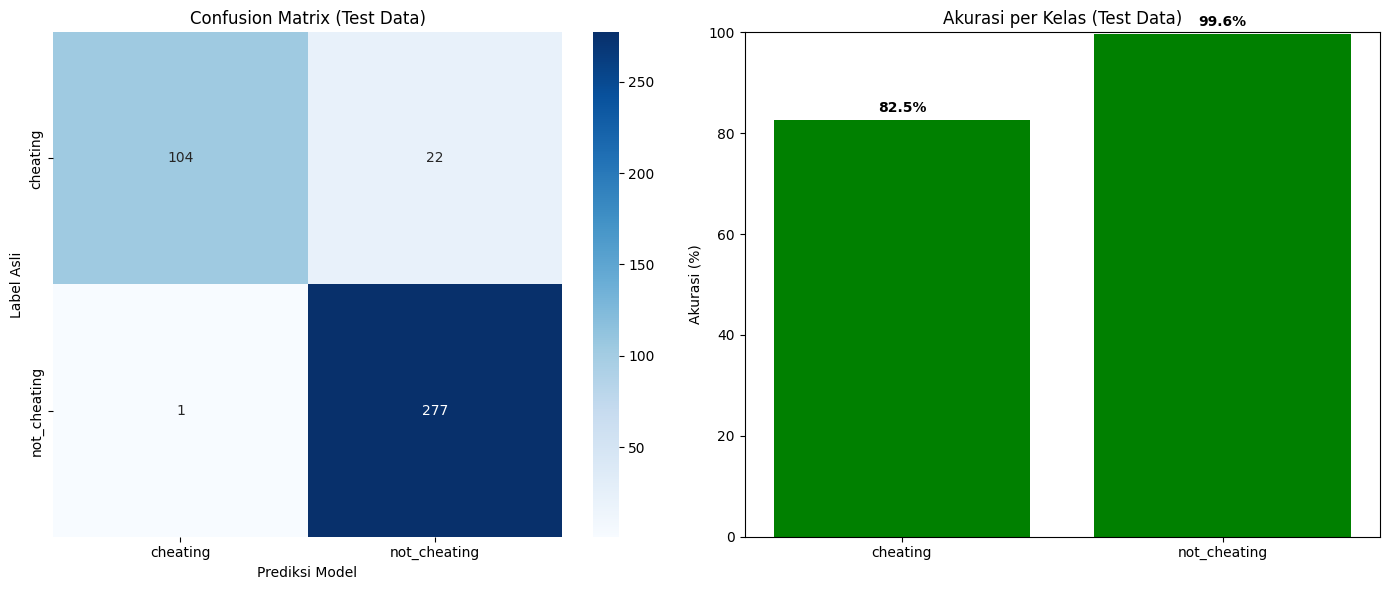

In [21]:
# --- TESTING PHASE ---
print("\n" + "="*40)
print("       MULAI PENGUJIAN DATA TEST       ")
print("="*40)

# 1. Load Model Terbaik
print(f"📥 Memuat model terbaik dari: {SAVE_PATH}")
checkpoint = torch.load(SAVE_PATH)
model.load_state_dict(checkpoint)
model.eval()

# 2. Variable untuk menyimpan hasil
all_preds = []
all_labels = []
correct = 0
total = 0

# 3. Loop Testing
print("🔄 Sedang memprediksi data test...")
with torch.no_grad():
    for clips, labels in tqdm(test_loader, desc="Testing"):
        clips, labels = clips.to(DEVICE), labels.to(DEVICE)

        outputs = model(clips)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 4. Hitung Akurasi Total
test_accuracy = 100 * correct / total
print(f"\n✅ Total Test Accuracy: {test_accuracy:.2f}%")
print("-" * 40)

# 5. Classification Report (Text)
print("\nDETAIL LAPORAN KLASIFIKASI:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# --- PLOT VISUALISASI HASIL TEST ---
plt.figure(figsize=(14, 6))

# Plot A: Confusion Matrix Heatmap
plt.subplot(1, 2, 1)
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Asli')
plt.title('Confusion Matrix (Test Data)')

# Plot B: Akurasi per Kelas (Bar Chart)
plt.subplot(1, 2, 2)
# Hitung akurasi per kelas dari Confusion Matrix
# Diagonal matrix dibagi jumlah baris (support)
class_acc = cm.diagonal() / cm.sum(axis=1) * 100

colors = ['green' if x > 50 else 'red' for x in class_acc]
bars = plt.bar(class_names, class_acc, color=colors)

plt.ylabel('Akurasi (%)')
plt.title('Akurasi per Kelas (Test Data)')
plt.ylim(0, 100)

# Tambah label angka di atas bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.1f}%", ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()